In [35]:
import math
import random
import datetime
from collections import defaultdict
from enum import Enum
import numpy as np 
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import Module
import gymnasium
from typing import (
    Type,
    List,
    Tuple,
)
import matplotlib.pyplot as plt
import stable_baselines3
from sb3_contrib import RecurrentPPO
from stable_baselines3 import PPO, DQN
import wandb

- See if there is transfer from learning regression models from a couple different sine curves to yet a different sine curve.
- We know there is transfer is (1) it takes less to train and (2) if the model chooses to reuse layers rather than create new ones.
- We first train regression models without the meta-learner (because the 'meta' ability cannot do anything without pre-trained weights).
- The meta-learner will then output actions to build a model for unseen data.
- Actions will be continuous, a vector of probabilities corresponding to which layer to add from the layer pool. One of these probabilities corresponds to adding no layer and just training the architecture as it is.

## config

In [37]:
default_config = {
    'seed' : 41,
    'device' : 'cuda',
    'episodic' : False,
    'epochs' : 5,
    'timesteps' : 100,
    'n_x' : 100,
    'n_tasks' : 1,
    'in_features' : 1,
    'out_features' : 1,
    'n_pool_hidden_layers' : 10,
    'n_layers_per_network' : 5,
    'n_nodes_per_layer' : 32,
    'pretrain' : False,
    'pool_layer_type' : torch.nn.Linear,
    'action_space_shape' : (3,),
    'epsilon' : 0.1,
    'batch_size' : 1,
    'learning_rate' : 0.01,
    'action_cache_size' : 5,
    'num_workers' : 0,
    'loss_fn' : torch.nn.MSELoss(),
    'sb3_model' : 'RecurrentPPO',
    'sb3_policy' : 'MlpLstmPolicy',
    'log_dir' : 'log',
    }
config = default_config
config

{'seed': 41,
 'device': 'cuda',
 'episodic': False,
 'epochs': 5,
 'timesteps': 100,
 'n_x': 100,
 'n_tasks': 1,
 'in_features': 1,
 'out_features': 1,
 'n_pool_hidden_layers': 10,
 'n_layers_per_network': 5,
 'n_nodes_per_layer': 32,
 'pretrain': False,
 'pool_layer_type': torch.nn.modules.linear.Linear,
 'action_space_shape': (3,),
 'epsilon': 0.1,
 'batch_size': 1,
 'learning_rate': 0.01,
 'action_cache_size': 5,
 'num_workers': 0,
 'loss_fn': MSELoss(),
 'sb3_model': 'RecurrentPPO',
 'sb3_policy': 'MlpLstmPolicy',
 'log_dir': 'log'}

In [38]:
wandb.init(
    project='reinforcement-meta-learning',
    config=config
)

loss_task0_per_step,▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁█▁▁▁▁▁▁▁
num_layers_task0_per_step,▆████▃█▁█████▆█▆████▆█▆▆▆▆█▃▁█▆██▃██████
reward_task0_per_step,█▇▁█▁▆██▆▆█▆▆███▁▇▆▆▆██▁▆██▁▁▇▆▁▁█▆▆▆██▆
running_loss_task0_per_100steps,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▃
running_reward_task0_per_100steps,▃▄▁▂▃▃▆▇▇█▇▇▇█▂▂▂▁▃▄▆██▇▇█▇▃▂▂▂▅▄▆▇▇██▇▅
loss_task0_per_step,0.00581
num_layers_task0_per_step,5
reward_task0_per_step,-1
running_loss_task0_per_100steps,38.93531
running_reward_task0_per_100steps,-18.0


In [39]:
torch.cuda.is_available()

True

## Reinforcement Meta-Learning (REML) / "Learning to Learn by Gradient Descent as a Markov Decision Process"

### sinusoidal curve regression as in MAML 2018 paper

In [40]:
lower_bound = torch.tensor(-5).float()
upper_bound = torch.tensor(5).float()
X = np.linspace(lower_bound, upper_bound, config['n_x'])
amplitude_range = torch.tensor([0.1, 5.0]).float()
phase_range = torch.tensor([0, math.pi]).float()
amps = torch.from_numpy(np.linspace(amplitude_range[0], amplitude_range[1], config['n_tasks'])).float()
phases = torch.from_numpy(np.linspace(phase_range[0], phase_range[1], config['n_tasks'])).float()
tasks_data = torch.tensor(np.array([ 
        X
        for _ in range(config['n_tasks'])
        ])).float()
tasks_targets = torch.tensor(np.array([
        [((a * np.sin(x)) + p).float()
        for x in X] 
        for a, p in zip(amps, phases)
        ])).float()
tasks_info = [
        {'i' : i, 
         'amp' : a, 
         'phase_shift' : p, 
         'lower_bound' : lower_bound, 
         'upper_bound' : upper_bound, 
         'amplitude_range_lower_bound' : amplitude_range[0], 
         'amplitude_range_upper_bound' : amplitude_range[1], 
         'phase_range_lower_bound' : phase_range[0],
         'phase_range_lower_bound' : phase_range[1]}
        for i, (a, p) in enumerate(zip(amps, phases))
]
print(f'[INFO] Tasks created.')

[INFO] Tasks created.


In [41]:
print(tasks_data.shape)
print(tasks_data.dtype)
print(tasks_targets.shape)
print(tasks_targets.dtype)
print(len(tasks_info))
print(len(tasks_info[0]))

torch.Size([1, 100])
torch.float32
torch.Size([1, 100])
torch.float32
1
8


In [42]:
class RegressionModel(torch.nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Linear(1, 32),  
            torch.nn.Linear(32, 32), 
            torch.nn.Linear(32, 32),  
            torch.nn.Linear(32, 32),  
            torch.nn.Linear(32, 1)  
        ])

    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = torch.nn.functional.leaky_relu(self.layers[i](x))
        x = self.layers[-1](x)
        return x

In [43]:
model = RegressionModel()
model

RegressionModel(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1-3): 3 x Linear(in_features=32, out_features=32, bias=True)
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [44]:
if config['pretrain']:
    layers = []
    data = []
    layer_weights_means = []
    layer_weights_stds = []
    for x, y in zip(tasks_data, tasks_targets):
        data.append([x,y])
    # fig, axs = plt.subplots(config['n_tasks'], 1, figsize=(12, 15))
    for i, (x, y) in enumerate(data):
        model = RegressionModel()
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 20000
        model.train()
        for epoch in range(num_epochs):
            optimizer.zero_grad() 
            outputs = model(x.view(-1, 1))
            loss = criterion(outputs, y.view(-1,1))
            loss.backward()
            optimizer.step()

        # save layers for layer pool
        layers.extend(model.layers)

In [45]:
class LayerPool:
    def __init__(self, 
                size: int=config['n_pool_hidden_layers'], 
                layer_constructor: Type[torch.nn.Linear]=config['pool_layer_type'],
                in_features: int=config['in_features'],
                out_features: int=config['out_features'],
                num_nodes_per_layer: int=config['n_nodes_per_layer'],
                layers: List[torch.nn.Linear]=None):
        self.size = size if layers is None else len(layers)
        self.layer_constructor = layer_constructor
        self.in_features = in_features
        self.out_features = out_features
        self.num_nodes_per_layer = num_nodes_per_layer

        if layers is None:
            self.layers = [self.layer_constructor(in_features=num_nodes_per_layer, out_features=num_nodes_per_layer)
                for _ in range(size)]
            for _ in range(config['n_tasks']):
                self.layers.append(self.layer_constructor(in_features=in_features, out_features=num_nodes_per_layer))
                self.layers.append(self.layer_constructor(in_features=num_nodes_per_layer, out_features=out_features))
            [torch.nn.init.xavier_uniform_(layer.weight) for layer in self.layers]
        else:
            self.layers = layers
            config['n_pool_hidden_layers'] = len(self.layers)
        
    def __str__(self) -> str:
        return f"LayerPool(size={self.size}, layer_type={config['pool_layer_type']}, num_nodes_per_layer={config['n_nodes_per_layer']}"


In [46]:
class InnerNetworkAction(Enum):
    TRAIN = 0
    ADDTRAIN = 1
    DELETETRAIN = 2
    ERROR = 3

In [47]:
class InnerNetworkTask(Dataset):
    def __init__(self, data, targets, info):
        self.data = data 
        self.targets = targets
        self.info = info

    def __len__(self):
        assert len(self.data) == config['n_x'], '[ERROR] Length should be the same as N_X.'
        return len(self.data)

    def __getitem__(self, index):
        assert self.data[index].dtype == torch.float32, f'[ERROR] Expected type torch.float32, got type: {self.data[index].dtype}'
        assert self.targets[index].dtype == torch.float32, f'[ERROR] Expected type torch.float32, got type: {self.targets[index].dtype}'
        sample = {
            'x' : self.data[index],
            'y' : self.targets[index],
            'info' : self.info
        }
        return sample
    
    def __str__(self):
        return f'[INFO] InnerNetworkTask(data={self.data, self.targets}, info={self.info})'

In [48]:
# TODO is to move this to utils
def get_params_and_gradients(layers):
    num_layers = len(layers)
    max_num_hidden_layers = config['n_layers_per_network'] - 2
    num_hidden_layers = num_layers - 2
    hidden_layers = layers[1:-1]
    params = [layer.weight.detach() for layer in hidden_layers]
    gradients = [layer.weight.grad for layer in hidden_layers]
    if num_hidden_layers < config['n_layers_per_network'] - 2: # zero pad the difference 
        zero_pad = [torch.zeros((config['n_nodes_per_layer'], config['n_nodes_per_layer']), dtype=torch.float32)] * (max_num_hidden_layers - num_hidden_layers)
        zero_pad_tensor = torch.stack(zero_pad)
        if len(params) > 0 and len(gradients) > 0:
            params = torch.stack(params)
            gradients = torch.stack(gradients)
            params = torch.cat((params, zero_pad_tensor))
            gradients = torch.cat((gradients, zero_pad_tensor)) 
        else:
            params = zero_pad_tensor
            gradients = zero_pad_tensor
    else:
        params = torch.stack(params)
        gradients = torch.stack(gradients)
    assert params.shape==(max_num_hidden_layers, config['n_nodes_per_layer'], config['n_nodes_per_layer']), f"[ERROR] Expected params shape={max_num_hidden_layers, config['n_nodes_per_layer'], config['n_nodes_per_layer']}, got {params.shape}"
    return params.view(-1), gradients.view(-1)

In [49]:
[tasks_info[0]['amp'], tasks_info[0]['phase_shift']]

[tensor(0.1000), tensor(0.)]

In [50]:
class InnerNetwork(gymnasium.Env, Module):
    def __init__(self, 
                epoch: int,
                task: InnerNetworkTask,
                layer_pool: LayerPool,
                in_features: int=config['in_features'],
                out_features: int=config['out_features'],
                learning_rate: float=config['learning_rate'],
                batch_size: int=config['batch_size'],
                epsilon: float=config['epsilon'],
                action_cache_size: float=config['action_cache_size'],
                num_workers: int=config['num_workers'],
                shuffle: bool=True,
                ):
        super(InnerNetwork, self).__init__()
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.layer_pool = layer_pool
        self.task = task
        self.in_features = in_features
        self.out_features = out_features
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.action_cache_size = action_cache_size
        self.alpha = torch.nn.Parameter(torch.Tensor([0.25]))
        self.num_workers = num_workers
        self.prev = defaultdict(lambda: None)
        self.curr = defaultdict(lambda: None)
        self.data_loader = DataLoader(task, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        self.data_iter = iter(self.data_loader)
        self.initial_layer = random.choice([layer for layer in self.layer_pool.layers if getattr(layer, 'in_features', None) == in_features])
        self.final_layer = random.choice([layer for layer in self.layer_pool.layers if getattr(layer, 'out_features', None) == out_features])
        self.layers = torch.nn.ModuleList([self.initial_layer, self.final_layer]) 
        self.layers_pool_indices = [self.layer_pool.layers.index(layer) for layer in self.layers] 
        self.loss_fn = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate)
        self.actions_taken = [InnerNetworkAction.TRAIN] * config['action_cache_size']
        self.next_batch()
        self.run_inner_network()
        self.observation_space = gymnasium.spaces.box.Box(low=float('-inf'), high=float('inf'), shape=self.build_state().shape)
        self.action_space = gymnasium.spaces.discrete.Discrete(len(self.layer_pool.layers) * 3)
        self.termination = False
        # log internal variables
        self.timestep = 0
        self.cum_loss = 0
        self.cum_reward = 0
        self.errors = 0
        self.rewards_per_episode = []
        self.steps_per_episode = []
        self.weight_means = defaultdict(lambda: [])
        self.weight_stds = defaultdict(lambda: [])

    def step(self, action: np.int64) -> Tuple[torch.Tensor, float, bool, dict]: 
        assert action.shape == (), f'[ERROR] Expected action shape () for scalar {self.action_space.n}, got: {action.shape}'
        assert action.dtype == np.int64, f'[ERROR] Expected np.int64 dtype, got: {action.dtype}'

        self.timestep += 1
        self.train()
        self.next_batch()
        self.update_inner_network(action)
        self.run_inner_network()
        s_prime = self.build_state()
        reward = self.reward()
        self.update_internal_trackers()
        self.log()

        return (
            s_prime,
            reward, 
            self.termination,
            False,
            {}
        )
    
    def decide_action_type(self, action: np.int64, greedy=False) -> np.int64:
        if random.random() < self.epsilon and not greedy: 
            action = random.randint(0, self.action_space.n - 1)
        add_action_type = action < self.layer_pool.size
        delete_action_type = action >= self.layer_pool.size and (action < self.layer_pool.size * 2)
        if (add_action_type):
            if (len(self.layers)==config['n_layers_per_network']):
                self.curr['action_type'] = InnerNetworkAction.ERROR
            elif self.layer_pool.layers[action].in_features==self.in_features or self.layer_pool.layers[action].out_features==self.out_features:
                self.curr['action_type'] = InnerNetworkAction.ERROR
            # limitation of layer pool design: can only use each layer once if updated the pool after
            elif self.layer_pool.layers[action] in self.layers:
                self.curr['action_type'] = InnerNetworkAction.ERROR
            else:
                self.curr['action_type'] = InnerNetworkAction.ADDTRAIN
        elif (delete_action_type):
            action = action - self.layer_pool.size
            if (self.layer_pool.layers[action] not in self.layers):
                self.curr['action_type'] = InnerNetworkAction.ERROR
            elif self.layer_pool.layers[action].in_features==self.in_features or self.layer_pool.layers[action].out_features==self.out_features:
                self.curr['action_type'] = InnerNetworkAction.ERROR
            else:
                self.curr['action_type'] = InnerNetworkAction.DELETETRAIN
        else:
            self.curr['action_type'] = InnerNetworkAction.TRAIN
        self.actions_taken.append(self.curr['action_type']) 
        self.termination = True if config['episodic'] and self.curr['action_type']==InnerNetworkAction.ERROR else False
        return action 
    
    def update_inner_network(self, action: np.int64) -> None:
        index = self.decide_action_type(action)
        if (self.curr['action_type']==InnerNetworkAction.ADDTRAIN): 
            new_layer = self.layer_pool.layers[index]
            final_layer = self.layers.pop(-1) 
            final_layer_index = self.layers_pool_indices.pop(-1)
            self.layers.append(new_layer)
            self.layers.append(final_layer) 
            self.layers_pool_indices.append(index)
            self.layers_pool_indices.append(final_layer_index)
        elif (self.curr['action_type']==InnerNetworkAction.DELETETRAIN):
            prev_layers_length = len(self.layers)
            index_within_layers = self.layers_pool_indices.index(index)
            success = self.layers.pop(index_within_layers)
            if success:
                self.layers_pool_indices.pop(index_within_layers)
            else:
                raise Exception('[ERROR] Delete on inner network failed.')
            assert prev_layers_length!=len(self.layers), '[ERROR] Delete on inner network failed.'
            
    def next_batch(self, throw_exception=False) -> None:
        self.prev = self.curr
        self.curr = defaultdict(lambda: None)

        if (throw_exception):
            batch = next(self.data_iter)
            self.curr['x'] = batch['x']
            self.curr['y'] = batch['y'] 
            self.curr['info'] = batch['info']
        else: 
            try:
                batch = next(self.data_iter)
            except StopIteration:
                self.data_loader = DataLoader(self.task, batch_size=self.batch_size, shuffle=self.shuffle, num_workers=self.num_workers)
                self.data_iter = iter(self.data_loader)
                batch = next(self.data_iter)
            finally:
                self.curr['x'] = batch['x']
                self.curr['y'] = batch['y'] 
                self.curr['info'] = batch['info']
    
    def run_inner_network(self) -> None: 
        if self.training:
            self.train()
            self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate) 
            self.opt.zero_grad()
            self.forward(self.curr['x'])
            loss = self.curr['loss']
            loss.backward()
            params_before = [param.data.clone() for param in self.layers.parameters()]
            self.opt.step()
            params_after = [param.data.clone() for param in self.layers.parameters()]
            for layers_index, (pool_index, param_before, param_after) in enumerate(zip(self.layers_pool_indices, params_before, params_after)):
                if torch.all(torch.eq(param_before, param_after)):
                    # print()
                    print('[INFO] Layer in environment not updated.')
                    # print(f'layer pool layer {pool_index} not updated')
                    # print(f'layers layer {self.layers[layers_index]}')
                    # print(f'weights {self.layers[layers_index].weight}')
                    # print(f'gradients {self.layers[layers_index].weight.grad}')
        else:
            self.forward(self.curr['x'])

    def forward(self, x) -> None:
        for i in range(len(self.layers) - 1): 
            x = torch.nn.functional.leaky_relu(self.layers[i](x))
        self.curr['latent_space'] = x
        self.curr['y_hat'] = self.layers[-1](x) 
        self.curr['loss'] = self.loss_fn(self.curr['y'], self.curr['y_hat'])
    
    def build_state(self) -> np.ndarray:
        task_info = torch.tensor([self.task.info['amp'], self.task.info['phase_shift']])
        loss = torch.Tensor([self.curr['loss']])
        _, gradients = get_params_and_gradients(self.layers)
        one_hot_layers = torch.tensor(np.array([1 if self.layer_pool.layers[i] in self.layers else 0 for i in range(len(self.layer_pool.layers))]))
        h = torch.tensor([action_enum.value for action_enum in self.actions_taken[-self.action_cache_size:]])
        layer_indices = self.layers_pool_indices.copy()
        while len(layer_indices) < config['n_layers_per_network']:
            layer_indices.insert(0, 0)
        layer_indices = torch.tensor(layer_indices)

        return torch.concat((
            task_info,
            self.curr['latent_space'],
            self.curr['y'],
            self.curr['y_hat'], 
            layer_indices,
            loss,
            gradients,
            one_hot_layers,
            h
        ), dim=0).detach().numpy()
    
    def reward(self) -> torch.Tensor:
        prev_loss = self.prev['loss'] or None
        curr_loss = self.curr['loss']
        loss_delta = prev_loss - curr_loss if prev_loss is not None else curr_loss
        if (self.curr['action_type'] == InnerNetworkAction.ERROR):
            reward = -5
        elif (self.curr['action_type'] == InnerNetworkAction.TRAIN):
            reward = 1 if loss_delta > 0 else -1
        else:
            reward = 1 * (0.99 ** self.timestep) if loss_delta > 0 else -1 * (0.99 ** self.timestep)
        self.curr['reward'] = reward
        return reward

    def update_internal_trackers(self) -> None:
        self.cum_loss += self.curr['loss']
        self.cum_reward += self.curr['reward']
        if config['episodic'] and self.curr['action_type']==InnerNetworkAction.ERROR:
            self.steps_per_episode.append(self.timestep)
            self.rewards_per_episode.append(self.cum_reward)
            self.errors += 1

    def log(self):
        task_num = str(self.curr['info']['i'].item())
        if self.timestep%100==0 and not config['episodic']:
            wandb.log({ f'running_loss_task{task_num}_per_100steps' : self.cum_loss})
            wandb.log({ f'running_reward_task{task_num}_per_100steps' : self.cum_reward})
            self.cum_loss = 0
            self.cum_reward = 0
        if (len(self.layers)!=0): wandb.log({ f'pool_indices_task{task_num}_per_step' : wandb.Histogram(torch.tensor(self.layers_pool_indices))})
        wandb.log({ f'action_types_task{task_num}_per_step' : wandb.Histogram(torch.tensor([e.value for e in self.actions_taken]))})
        wandb.log({ f'num_layers_task{task_num}_per_step' : len(self.layers) })
        wandb.log({ f'loss_task{task_num}_per_step' : self.curr['loss'] })
        wandb.log({ f'reward_task{task_num}_per_step' : self.curr['reward'] })

    def reset(self, seed=None) -> np.ndarray:
        print(f'[INFO] Reset at {self.timestep}')
        self.timestep = 0
        self.cum_reward = 0
        self.cum_loss = 0
        self.eval()
        self.next_batch()
        self.run_inner_network()
        return self.build_state(), None

In [95]:
class REML:
    def __init__(
        self,
        layer_pool: LayerPool,
        tasks: List[InnerNetworkTask],
        model=config['sb3_model'],
        policy=config['sb3_policy'],
        epochs: int=config['epochs'],
        timesteps: int=config['timesteps'],
        device: str=config['device'],
        overwrite: bool=True,  # TODO is to revisit this param
        intra_update: bool=True, # TODO is to revisit this param
        log_dir: str=f"./{config['log_dir']}/{config['sb3_model']}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
        ):
        self.layer_pool = layer_pool
        self.tasks = tasks
        if config['sb3_model']=='PPO':
            self.model = PPO
        elif config['sb3_model']=='RecurrentPPO':
            self.model = RecurrentPPO
        elif config['sb3_model']=='DQN':
            self.model = DQN
        self.policy = policy
        self.epochs = epochs
        self.timesteps = timesteps
        self.device = device
        self.overwrite = overwrite 
        self.intra_update = intra_update
        self.log_dir = log_dir
    
    def __str__(self) -> str:
        return f'REML(model={self.model}, policy={self.policy})'

    def train(self):
        # wraps stablebaselines learn() so we call it n * m times
        # n is the number of epochs where we run all m tasks
        # we use the same policy, swapping out envs for the n tasks, m times. 
        # therefore the number of steps is (timesteps)*(n)*(m)
        initial_setup = True
        for epoch in range(self.epochs):
            print(f'[INFO] Epoch={epoch + 1}/{self.epochs}')
            for i, task in enumerate(self.tasks): 
                print(f'[INFO] Task={i+1}/{len(self.tasks)}')

                # each task gets its own network
                # TODO is to learn more about this wrapper and how its different from normalizing within the env
                # TODO is to look at normalizing action space too 
                self.env = gymnasium.wrappers.NormalizeObservation(InnerNetwork(epoch, task, self.layer_pool))
                if initial_setup:
                    self.model = self.model(self.policy, self.env, tensorboard_log=self.log_dir, n_epochs=5, batch_size=32, n_steps=32)
                    initial_setup = False
                else: 
                    self.model.set_env(self.env)
                self.model.learn(total_timesteps=self.timesteps)

		        # pool update
                for pool_index in self.env.layers_pool_indices:
                    index_within_layers = self.env.layers_pool_indices.index(pool_index)
                    updated_pool_layer = self.env.layers[index_within_layers]
                    self.layer_pool.layers[pool_index] = self.env.layers[index_within_layers]
                    assert updated_pool_layer.in_features==self.layer_pool.layers[pool_index].in_features, '[ERROR] Pool layer to be updated did not match the environment layer.'
                    assert updated_pool_layer.out_features==self.layer_pool.layers[pool_index].out_features, '[ERROR] Pool layer to be updated did not match the environment layer.'
                    env_layer_params = [param.data.clone() for param in self.env.layers.parameters()]
                    corresponding_pool_layer_params = [param.data.clone() for param in torch.nn.ModuleList([self.env.layer_pool.layers[index] for index in self.env.layers_pool_indices]).parameters()]
                    for param_before, param_after in zip(env_layer_params, corresponding_pool_layer_params):
                        if not torch.all(torch.eq(param_before, param_after)):
                            print('[ERROR] Layers in pool not updated.')

                # wandb 
                if config['episodic']:
                    wandb.log({ f'average_reward_per_episode_task{i}_per_epoch' : sum(self.env.rewards_per_episode) / len(self.env.rewards_per_episode) }) 
                    wandb.log({ f'average_steps_per_episode_task{i}_per_epoch' : sum(self.env.steps_per_episode) / len(self.env.steps_per_episode) }) 
                    wandb.log({ f'errors_per_epoch_task{i}_per_epoch' : self.env.errors })

                yhats = self.evaluate_inner_network()
                plot_name = f'sine_curve_epoch_{epoch}_task_{i}'
                plot_path = f'{self.log_dir}/{plot_name}.png'  
                plt.figure()
                plt.plot(self.env.task.data, [yhat.detach().numpy() for yhat in yhats])
                plt.plot(self.env.task.data, self.env.task.targets)
                plt.title(plot_name)
                plt.savefig(plot_path)
                wandb.log({plot_name: wandb.Image(plot_path)})

    def evaluate_inner_network(self) -> List[torch.Tensor]:
        obs, _ = self.env.reset()
        self.env.eval()
        y_hats = []
        i = 0
        while True:
            action, _ = self.model.predict(obs)
            obs, _, _, _, _ = self.env.step(action)
            if i > 100 and len(self.env.layers)==config['n_layers_per_network']:
                for x in X:
                    x = torch.Tensor([x])
                    for i in range(len(self.env.layers) - 1): 
                        x = torch.nn.functional.leaky_relu(self.env.layers[i](x))
                    y_hats.append(self.env.layers[-1](x))
                break
            i += 1
        return y_hats

### testing

In [96]:
tasks = [InnerNetworkTask(data=tasks_data[i], targets=tasks_targets[i], info=tasks_info[i]) for i in range(config['n_tasks'])]
pool = LayerPool(layers=layers) if config['pretrain'] else LayerPool(layers=None)
model = REML(layer_pool=pool, tasks=tasks)

In [97]:
model.__str__()

"REML(model=<class 'sb3_contrib.ppo_recurrent.ppo_recurrent.RecurrentPPO'>, policy=MlpLstmPolicy)"

[INFO] Epoch=1/5
[INFO] Task=1/1
[INFO] Reset at 0
[INFO] Reset at 128
[INFO] Epoch=2/5
[INFO] Task=1/1
[INFO] Reset at 0
[INFO] Reset at 128
[INFO] Epoch=3/5
[INFO] Task=1/1
[INFO] Reset at 0
[INFO] Reset at 128
[INFO] Epoch=4/5
[INFO] Task=1/1
[INFO] Reset at 0
[INFO] Reset at 128
[INFO] Epoch=5/5
[INFO] Task=1/1
[INFO] Reset at 0
[INFO] Reset at 128


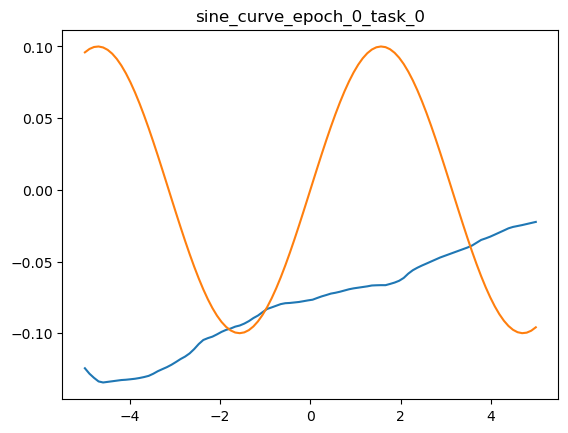

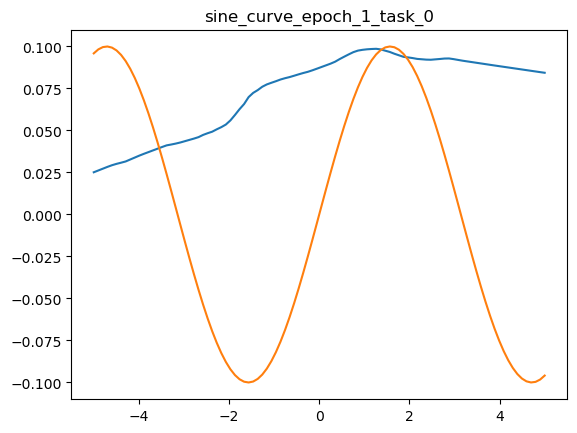

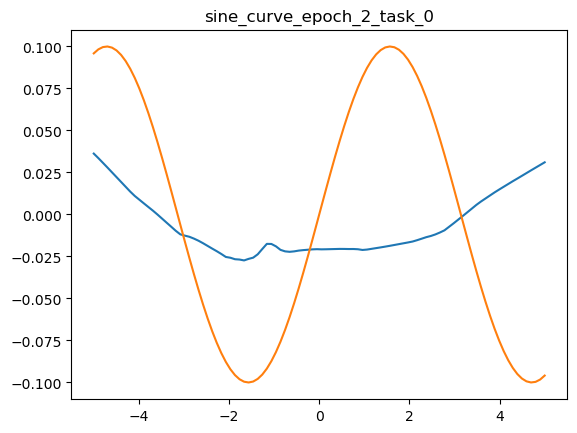

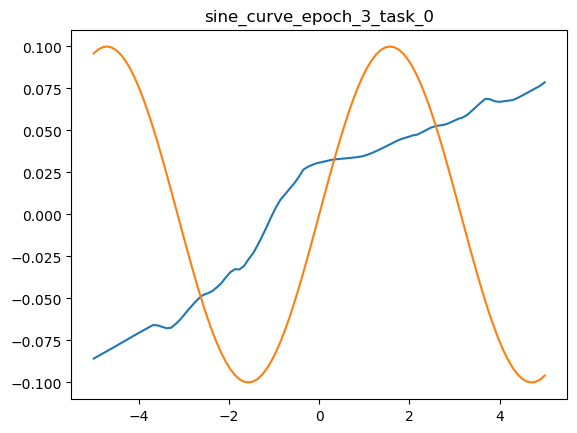

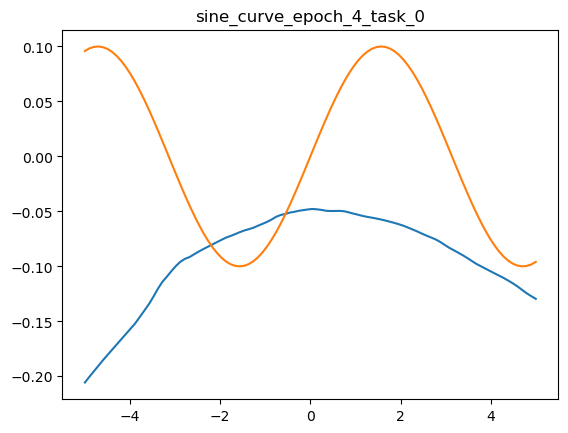

In [98]:
model.train()